In [181]:
import itertools

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as sps
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [182]:
data = pd.read_csv('../data/amsterdam_weekdays.csv')

data["person_capacity"] = data["person_capacity"].astype(int)
data["cleanliness_rating"] = data["cleanliness_rating"].astype(int)
data["host_is_superhost"] = data["host_is_superhost"].astype('category')
# data["realSum"] = data["realSum"].clip(0, 4000)

In [183]:
data.head()

,realSum,room_type,person_capacity,host_is_superhost,cleanliness_rating,bedrooms,dist,metro_dist
0,194.033698,Private room,2,False,10,1,5.022964,2.539380
1,344.245776,Private room,4,False,8,1,0.488389,0.239404
2,264.101422,Private room,2,False,9,1,5.748312,3.651621
3,433.529398,Private room,4,False,9,2,0.384862,0.439876
4,485.552926,Private room,2,True,10,1,0.544738,0.318693


## Анализ переменных

In [184]:
numerical_columns = [
    'realSum',
    'dist',
    'metro_dist'
]

categorical_columns = [
    'person_capacity',
    'cleanliness_rating',
    'bedrooms',
    'room_type',
    'host_is_superhost'
]

In [185]:
def describe_column(dataframe, column_name):
    data = dataframe[column_name]
    cnt, mean, std, *quartiles = data.describe()
    x_min, lower_quartile, x_median, upper_quartile, x_max = quartiles
    interquartile_range = upper_quartile - lower_quartile
    skewness = sps.skew(data)
    kurtosis = sps.kurtosis(data)
    return {
        "variable": column_name,
        "cnt": cnt,
        "mean": mean,
        "std": std,
        "x_min": x_min,
        "lower_quartile": lower_quartile,
        "upper_quartile": upper_quartile,
        "x_min": x_min,
        "x_max": x_max,
        "x_median": x_median,
        "skewness": skewness,
        "kurtosis": kurtosis,
        "interquartile_range": interquartile_range,
    }

In [186]:
stat_dicts = []
for col in numerical_columns:
    stat_dicts.append(describe_column(data, col))

column_stats = pd.DataFrame(stat_dicts).set_index('variable').T

In [187]:
column_stats

variable,realSum,dist,metro_dist
cnt,1103.000000,1103.000000,1103.000000
mean,545.020526,2.841621,1.089439
std,416.974314,2.123245,0.836546
x_min,128.887118,0.015059,0.036530
lower_quartile,309.797764,1.302058,0.462983
upper_quartile,657.324303,3.648138,1.510629
x_max,7782.907225,11.187100,4.411915
x_median,430.248635,2.341366,0.856010
skewness,6.423628,1.454982,1.367371
kurtosis,87.636176,2.261120,1.796988


### Графики для количественных переменных

In [188]:
def plot_hist_density(dataframe, column_name, ax, stat='density'):
    data = dataframe[column_name].clip(-4000, 4000)
    sns.histplot(data, ax=ax, stat=stat)
    if stat == 'density':
        _, mu, sigma, *_ = data.describe()
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        density = sps.norm.pdf(x, mu, sigma)
        sns.lineplot(x=x, y=density, color='red', ax=ax, label=f'$Norm$({mu:.1f}, {sigma:.1f})')

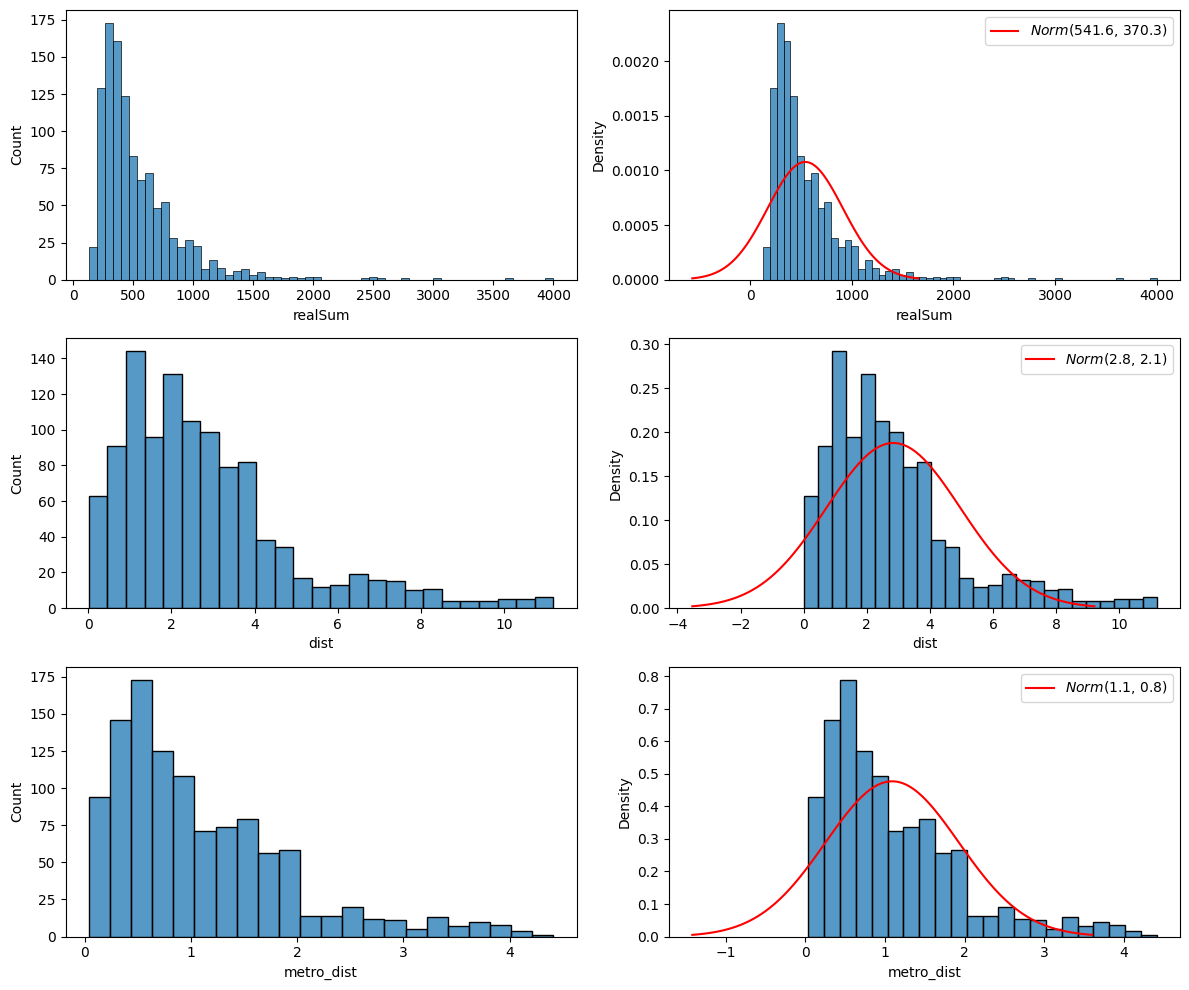

In [189]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i in range(3):
    col = numerical_columns[i]
    plot_hist_density(data, col, ax[i%3][0], stat='count')
    plot_hist_density(data, col, ax[i%3][1], stat='density')

plt.tight_layout()
plt.show()

#### Выбросы

In [190]:
for col in numerical_columns:
    data[f'{col}_outlier'] = (data[col] - column_stats[col]['mean']).abs() > 3 * column_stats[col]['std']

In [191]:
print('Количество выбросов:')
print(data[[f'{col}_outlier' for col in numerical_columns]].sum())

Количество выбросов:
realSum_outlier       15
dist_outlier          23
metro_dist_outlier    23
dtype: int64


### Номинальные переменные

In [192]:
from IPython.display import display

In [193]:
cat_variable_stats = []
means = []

for col in categorical_columns:
    group_cnts = data[col].value_counts()
    group_freqs = group_cnts / group_cnts.sum()
    cat_variable_stats.append(pd.DataFrame({"cnt": group_cnts, "freqs": group_freqs}))

for var in cat_variable_stats:
    display(var.sort_index())
    print('=' * 60)

,cnt,freqs
person_capacity,,
2,656,0.594742
3,79,0.071623
4,333,0.301904
5,11,0.009973
6,24,0.021759


,cnt,freqs
cleanliness_rating,,
4,2,0.001813
5,1,0.000907
6,9,0.008160
7,11,0.009973
8,87,0.078876
9,334,0.302811
10,659,0.597461


,cnt,freqs
bedrooms,,
0,83,0.075249
1,719,0.651859
2,218,0.197643
3,74,0.067090
4,7,0.006346
5,2,0.001813


,cnt,freqs
room_type,,
Entire home/apt,538,0.487761
Private room,559,0.506800
Shared room,6,0.005440


,cnt,freqs
host_is_superhost,,
False,780,0.707162
True,323,0.292838


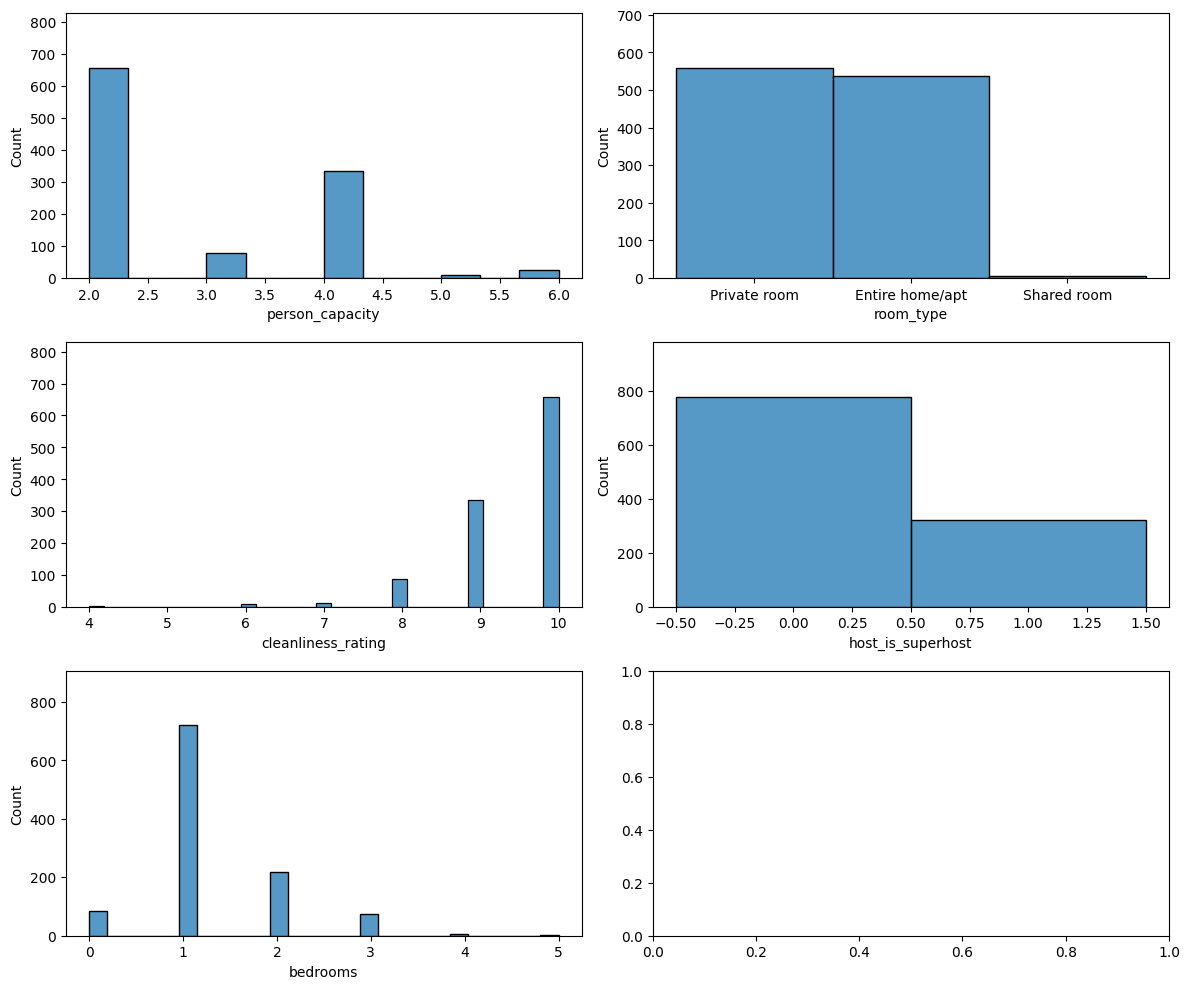

In [194]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i in range(5):
    ax = axes[i%3][i//3]
    sns.histplot(data[categorical_columns[i]], ax=ax)
    l, h = ax.get_ylim()
    ax.set_ylim(l, h * 1.2)

plt.tight_layout()
plt.show()

#### Проведем укрупнение

In [195]:
data['cleanliness_rating_grouped'] = data['cleanliness_rating'].map({
    4: '8 or less',
    5: '8 or less',
    6: '8 or less',
    7: '8 or less',
    8: '8 or less',
    9: '9',
    10: '10',
}).astype('category')

In [196]:
data['bedrooms_grouped'] = data['bedrooms'].map({
    0: '0',
    1: '1',
    2: '2',
    3: '3+',
    4: '3+',
    5: '3+',
}).astype('category')

In [197]:
data['person_capacity_grouped'] = data['person_capacity'].map({
    2: '2',
    3: '3',
    4: '4+',
    5: '4+',
    6: '4+',
}).astype('category')

In [198]:
data['room_type_grouped'] = data['room_type'].map({
    'Private room': 'room',
    'Shared room': 'room',
    'Entire home/apt': 'entire home/apt',
}).astype('category')

In [199]:
grouped_categorical_columns = [
    'person_capacity_grouped',
    'cleanliness_rating_grouped',
    'bedrooms_grouped',
    'room_type_grouped',
    'host_is_superhost'
]

In [200]:
grouped_cat_variable_stats = []

for col in grouped_categorical_columns:
    group_cnts = data[col].value_counts()
    group_freqs = group_cnts / group_cnts.sum()
    grouped_cat_variable_stats.append(pd.DataFrame({"cnt": group_cnts, "freqs": group_freqs}))

for var in grouped_cat_variable_stats:
    display(var.sort_index())
    print('=' * 60)

,cnt,freqs
person_capacity_grouped,,
2,656,0.594742
3,79,0.071623
4+,368,0.333636


,cnt,freqs
cleanliness_rating_grouped,,
10,659,0.597461
8 or less,110,0.099728
9,334,0.302811


,cnt,freqs
bedrooms_grouped,,
0,83,0.075249
1,719,0.651859
2,218,0.197643
3+,83,0.075249


,cnt,freqs
room_type_grouped,,
entire home/apt,538,0.487761
room,565,0.512239


,cnt,freqs
host_is_superhost,,
False,780,0.707162
True,323,0.292838


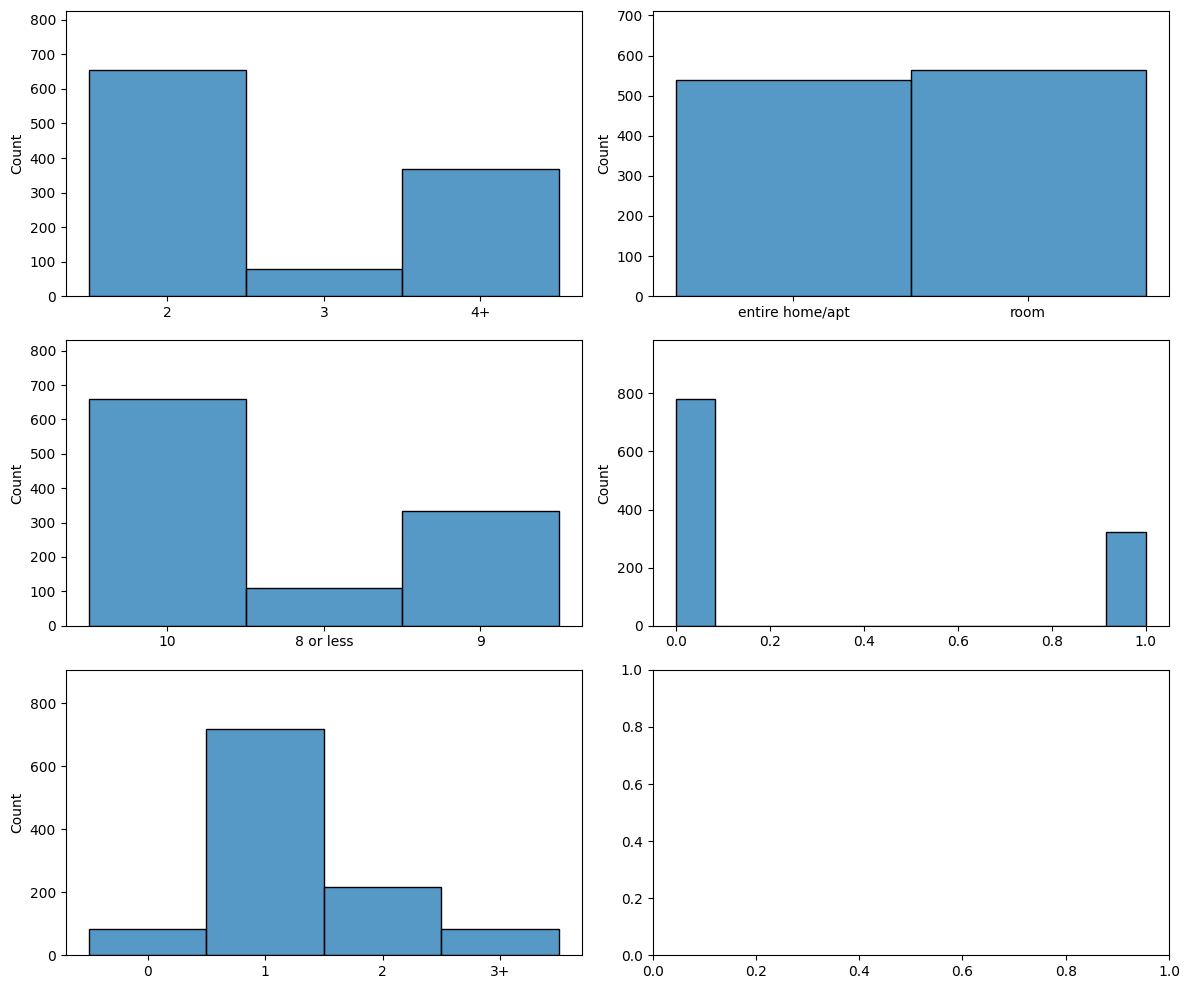

In [201]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i in range(5):
    ax = axes[i%3][i//3]
    sns.histplot(sorted(data[grouped_categorical_columns[i]]), ax=ax)
    l, h = ax.get_ylim()
    ax.set_ylim(l, h * 1.2)

plt.tight_layout()
plt.show()

## Анализ статистической связи

### Порядковые и номинальные переменные

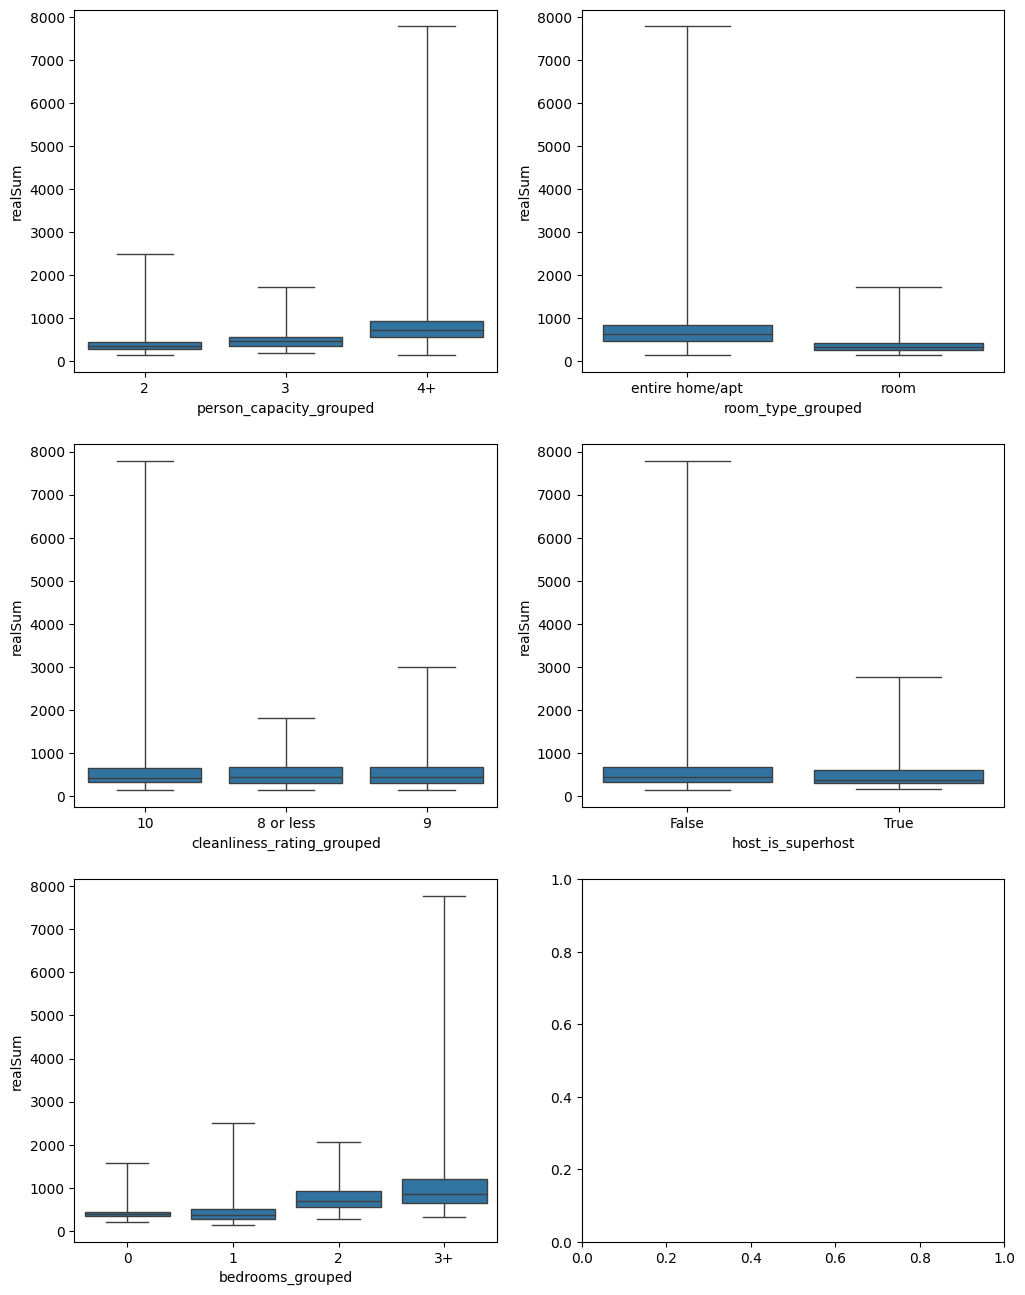

In [203]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12, 16))

for i in range(5):
    ax = axes[i%3][i//3]
    col = grouped_categorical_columns[i]
    sns.boxplot(data=data, x=col, y="realSum", ax=ax, whis=(0, 100))

plt.show()

In [23]:
for i in range(5):
    col = grouped_categorical_columns[i]
    subsets = []
    for val in data[col].unique():
        subsets.append(data["realSum"][data[col] == val])
    print(f'Kruskal test for {col}')
    test_res = sps.kruskal(*subsets)
    print(f'p-value = {test_res.pvalue:.5f}')
    print(f'Null hypothesis is rejected: {test_res.pvalue < 0.05}')
    print()

Kruskal test for person_capacity_grouped
p-value = 0.00000
Null hypothesis is rejected: True

Kruskal test for cleanliness_rating_grouped
p-value = 0.88646
Null hypothesis is rejected: False

Kruskal test for bedrooms_grouped
p-value = 0.00000
Null hypothesis is rejected: True

Kruskal test for room_type_grouped
p-value = 0.00000
Null hypothesis is rejected: True

Kruskal test for host_is_superhost
p-value = 0.00051
Null hypothesis is rejected: True



### Количественные переменные

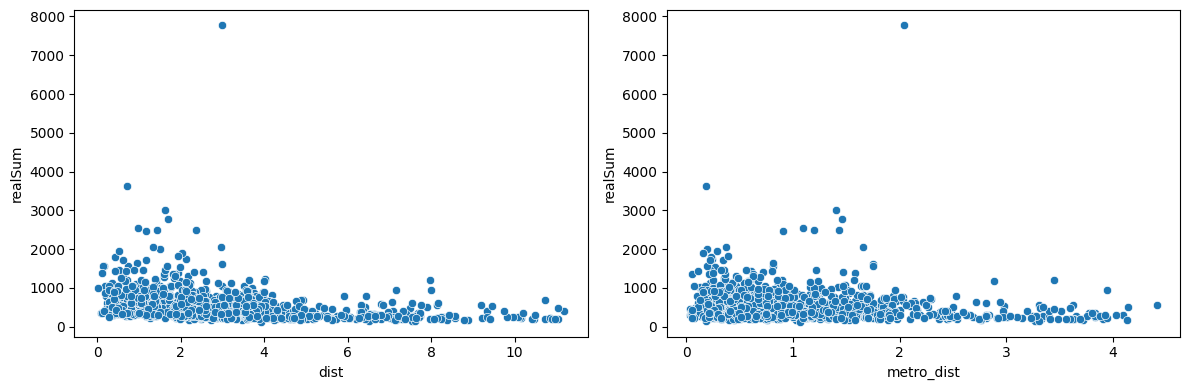

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

for i in range(2):
    ax = axes[i]
    col = numerical_columns[1:][i]
    sns.scatterplot(data=data, x=col, y="realSum", ax=ax)

plt.tight_layout()
plt.show()

In [26]:
corr_dicts = []
tests = [sps.kendalltau, sps.pearsonr, sps.spearmanr]

for col in numerical_columns[1:]:
    a, b = data[col], data["realSum"]
    for test in tests:
        corr = test(a, b)
        corr_dicts.append({
            'variable': col,
            'test': test.__name__,
            'test statistic': corr.statistic,
            'test p-value': corr.pvalue,
            'null hypothesis rejected': corr.pvalue < 0.05,
        })

In [27]:
pd.DataFrame(corr_dicts).set_index(['variable', 'test'])

test statistic  test p-value  null hypothesis rejected
variable   test                                                              
dist       kendalltau       -0.264824  1.617648e-39                      True
           pearsonr         -0.258692  2.528289e-18                      True
           spearmanr        -0.389795  2.436400e-41                      True
metro_dist kendalltau       -0.131207  7.170382e-11                      True
           pearsonr         -0.142298  2.087936e-06                      True
           spearmanr        -0.192857  1.057368e-10                      True

### Анализ таблиц - связи между независимыми переменными

#### Независимая номинальная - независимая номинальная

In [28]:
def cramer_v(confusion_matrix):
    n_observations = confusion_matrix.sum()
    min_shape = min(*confusion_matrix.shape)
    v_cramer_stat = np.sqrt(chi2_stat / (min_shape * n_observations))
    return v_cramer_stat

In [30]:
for left, right in itertools.combinations(grouped_categorical_columns, 2):
    confusion_matrix = pd.crosstab(data[left], data[right]).to_numpy()
    res = sps.chi2_contingency(confusion_matrix)
    chi2_stat, pval = res.statistic, res.pvalue
    v_cramer_stat = cramer_v(confusion_matrix)
    print(f'{left} to {right}:')
    print(f'Chi Squared statistic = {chi2_stat:.4f}')
    print(f'Chi Squared test p_value = {pval:.4f}')
    print(f'Null hypothesis rejected: {pval < 0.05}')
    print(f'Cramer\'s V = {v_cramer_stat:.4f}')
    display(pd.crosstab(data[left], data[right], margins=True))
    print('=' * 60)

person_capacity_grouped to cleanliness_rating_grouped:
Chi Squared statistic = 14.0116
Chi Squared test p_value = 0.0073
Null hypothesis rejected: True
Cramer's V = 0.0651


cleanliness_rating_grouped,10,8 or less,9,All
person_capacity_grouped,,,,
2,420,57,179,656
3,47,9,23,79
4+,192,44,132,368
All,659,110,334,1103


person_capacity_grouped to bedrooms_grouped:
Chi Squared statistic = 601.8884
Chi Squared test p_value = 0.0000
Null hypothesis rejected: True
Cramer's V = 0.4265


bedrooms_grouped,0,1,2,3+,All
person_capacity_grouped,,,,,
2,66,580,10,0,656
3,9,45,21,4,79
4+,8,94,187,79,368
All,83,719,218,83,1103


person_capacity_grouped to room_type_grouped:
Chi Squared statistic = 149.9516
Chi Squared test p_value = 0.0000
Null hypothesis rejected: True
Cramer's V = 0.2607


room_type_grouped,entire home/apt,room,All
person_capacity_grouped,,,
2,223,433,656
3,44,35,79
4+,271,97,368
All,538,565,1103


person_capacity_grouped to host_is_superhost:
Chi Squared statistic = 11.2659
Chi Squared test p_value = 0.0036
Null hypothesis rejected: True
Cramer's V = 0.0715


host_is_superhost,False,True,All
person_capacity_grouped,,,
2,439,217,656
3,60,19,79
4+,281,87,368
All,780,323,1103


cleanliness_rating_grouped to bedrooms_grouped:
Chi Squared statistic = 12.4457
Chi Squared test p_value = 0.0527
Null hypothesis rejected: False
Cramer's V = 0.0613


bedrooms_grouped,0,1,2,3+,All
cleanliness_rating_grouped,,,,,
10,39,454,120,46,659
8 or less,9,67,24,10,110
9,35,198,74,27,334
All,83,719,218,83,1103


cleanliness_rating_grouped to room_type_grouped:
Chi Squared statistic = 1.6707
Chi Squared test p_value = 0.4337
Null hypothesis rejected: False
Cramer's V = 0.0275


room_type_grouped,entire home/apt,room,All
cleanliness_rating_grouped,,,
10,311,348,659
8 or less,57,53,110
9,170,164,334
All,538,565,1103


cleanliness_rating_grouped to host_is_superhost:
Chi Squared statistic = 135.4589
Chi Squared test p_value = 0.0000
Null hypothesis rejected: True
Cramer's V = 0.2478


host_is_superhost,False,True,All
cleanliness_rating_grouped,,,
10,381,278,659
8 or less,107,3,110
9,292,42,334
All,780,323,1103


bedrooms_grouped to room_type_grouped:
Chi Squared statistic = 215.4484
Chi Squared test p_value = 0.0000
Null hypothesis rejected: True
Cramer's V = 0.3125


room_type_grouped,entire home/apt,room,All
bedrooms_grouped,,,
0,29,54,83
1,255,464,719
2,175,43,218
3+,79,4,83
All,538,565,1103


bedrooms_grouped to host_is_superhost:
Chi Squared statistic = 14.3349
Chi Squared test p_value = 0.0025
Null hypothesis rejected: True
Cramer's V = 0.0806


host_is_superhost,False,True,All
bedrooms_grouped,,,
0,66,17,83
1,484,235,719
2,161,57,218
3+,69,14,83
All,780,323,1103


room_type_grouped to host_is_superhost:
Chi Squared statistic = 32.4697
Chi Squared test p_value = 0.0000
Null hypothesis rejected: True
Cramer's V = 0.1213


host_is_superhost,False,True,All
room_type_grouped,,,
entire home/apt,424,114,538
room,356,209,565
All,780,323,1103


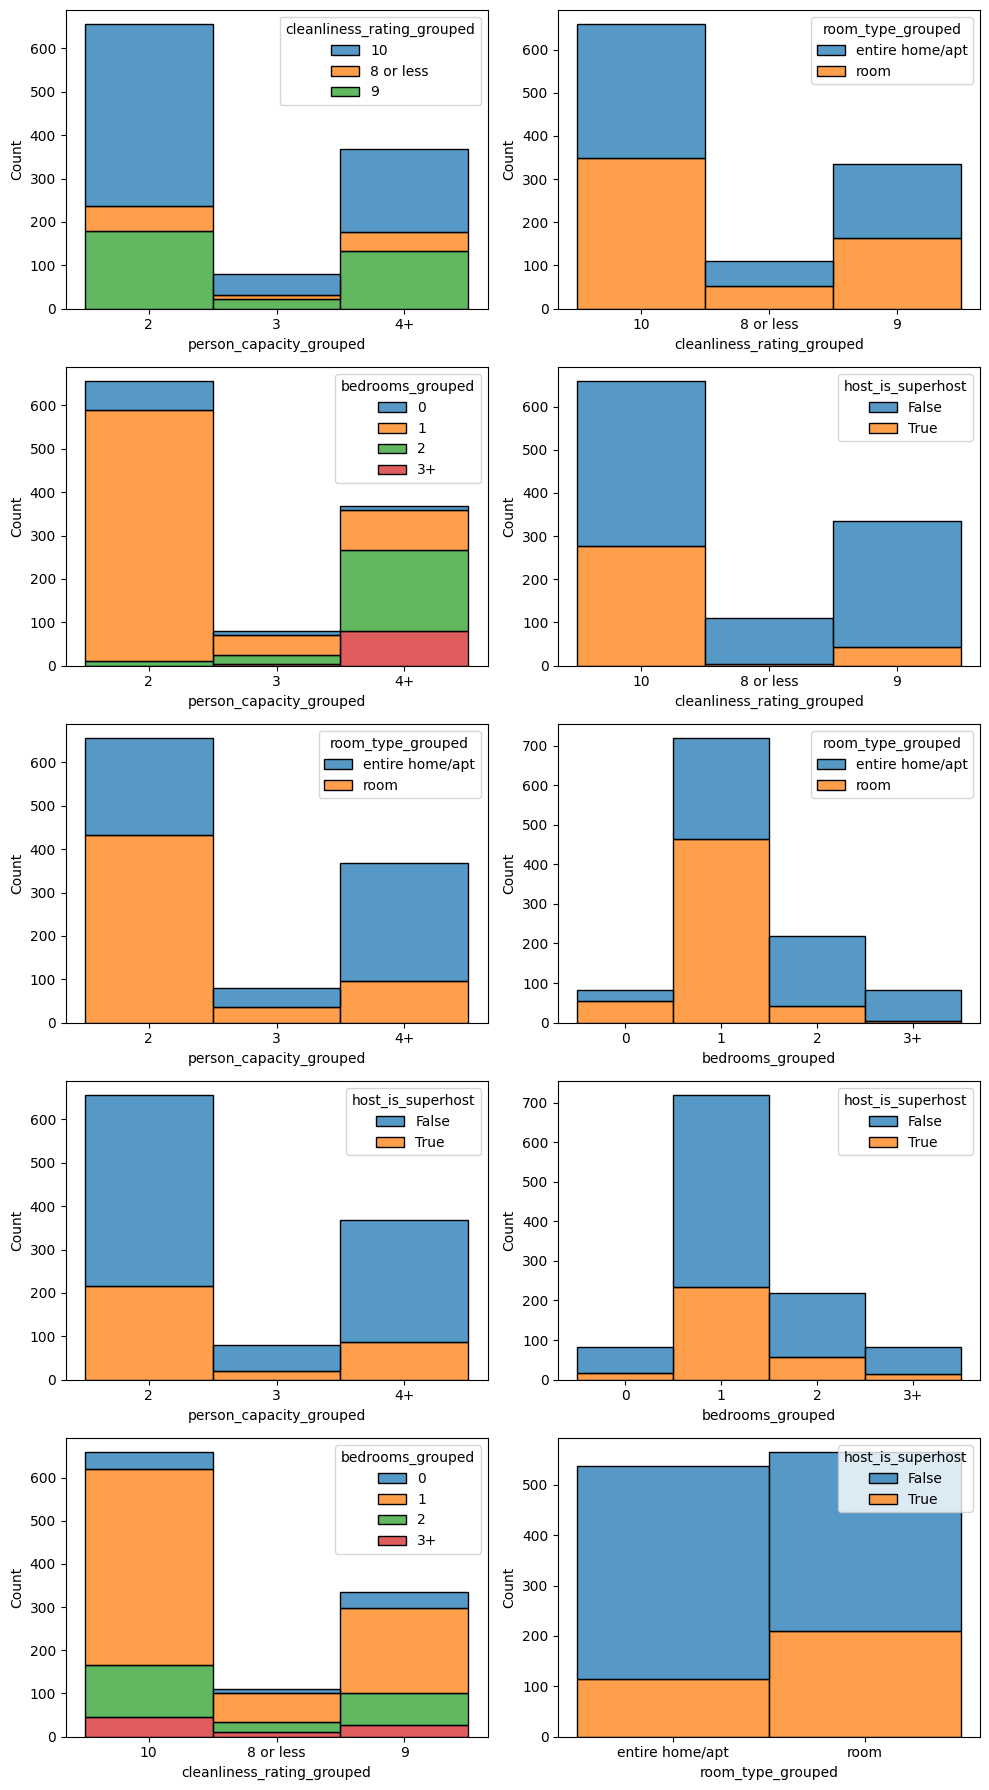

In [223]:
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(10, 18))
for i, (left, right) in enumerate(itertools.combinations(grouped_categorical_columns, 2)):
    sns.histplot(data=data, x=left, hue=right, ax=axes[i%5][i//5], multiple="stack")
plt.tight_layout()
plt.show()

#### Независимая качественная - независимая количественная

In [31]:
cat2num_dicts = []
for col in grouped_categorical_columns:
    for num_col in numerical_columns[1:]:
        subsets = []
        for val in data[col].unique():
            subsets.append(data[num_col][data[col] == val])
        test_res = sps.kruskal(*subsets)
        cat2num_dicts.append({
            'numerical': num_col,
            'categorical': col,
            'p-value': test_res.pvalue,
            'rejected': test_res.pvalue < 0.05,
            'statistic': test_res.statistic,
        })

pd.DataFrame(cat2num_dicts).set_index(['categorical', 'numerical'])

p-value  rejected  statistic
categorical                numerical                                
person_capacity_grouped    dist        0.209827     False   3.122948
                           metro_dist  0.265172     False   2.654752
cleanliness_rating_grouped dist        0.545021     False   1.213863
                           metro_dist  0.516005     False   1.323277
bedrooms_grouped           dist        0.001971      True  14.826694
                           metro_dist  0.078723     False   6.795116
room_type_grouped          dist        0.231085     False   1.434169
                           metro_dist  0.779579     False   0.078326
host_is_superhost          dist        0.551784     False   0.354131
                           metro_dist  0.268882     False   1.222441

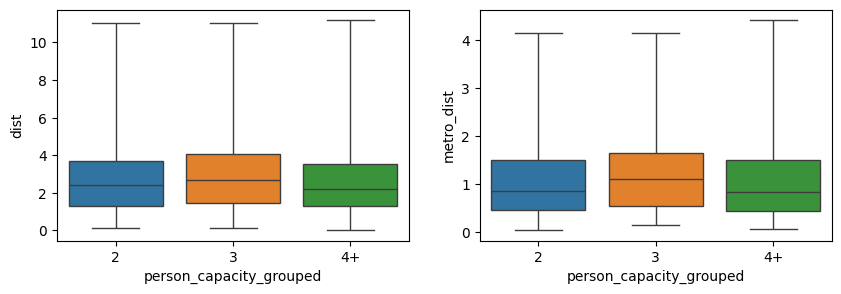

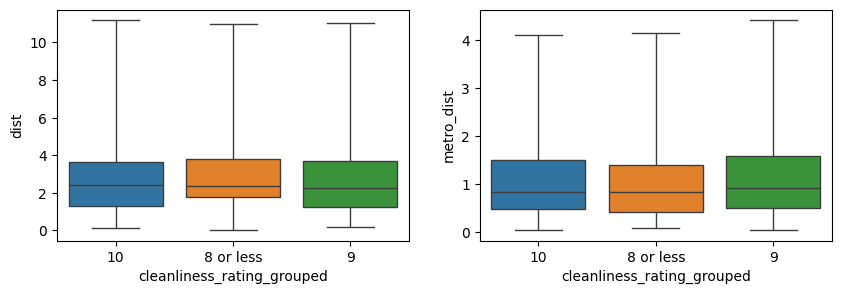

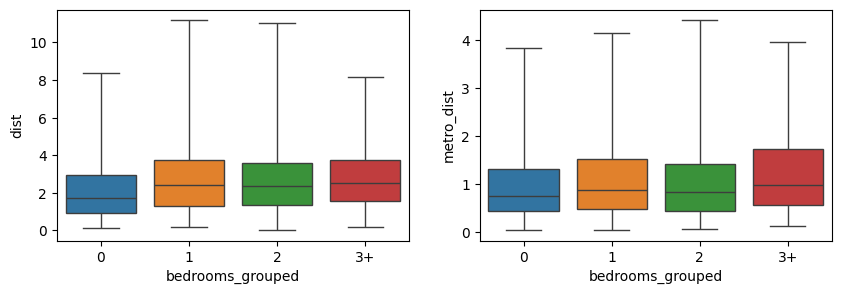

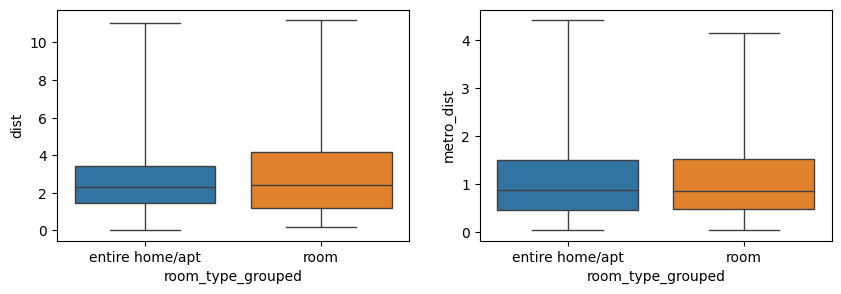

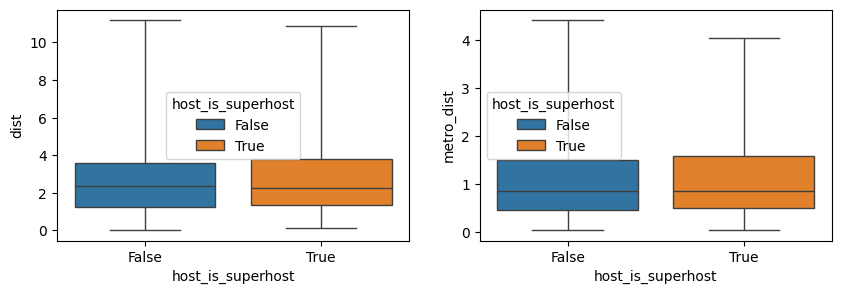

In [35]:
for cat_col in grouped_categorical_columns:
    fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
    sns.boxplot(data=data, x=cat_col, y='dist', hue=cat_col, ax=axes[0], whis=(0, 100))
    sns.boxplot(data=data, x=cat_col, y='metro_dist', hue=cat_col, ax=axes[1], whis=(0, 100))
plt.show()

#### Независимая количественная - Независимая количественная

In [36]:
corr_dicts = []
tests = [sps.kendalltau, sps.pearsonr, sps.spearmanr]

a, b = data['metro_dist'], data['dist']
for test in tests:
    corr = test(a, b)
    corr_dicts.append({
        'test': test.__name__,
        'test statistic': corr.statistic,
        'test p-value': corr.pvalue,
        'null hypothesis rejected': corr.pvalue < 0.05,
    })

pd.DataFrame(corr_dicts).set_index(['test'])

,test statistic,test p-value,null hypothesis rejected
test,,,
kendalltau,0.290350,2.836351e-47,True
pearsonr,0.412042,1.907484e-46,True
spearmanr,0.401195,6.585973e-44,True


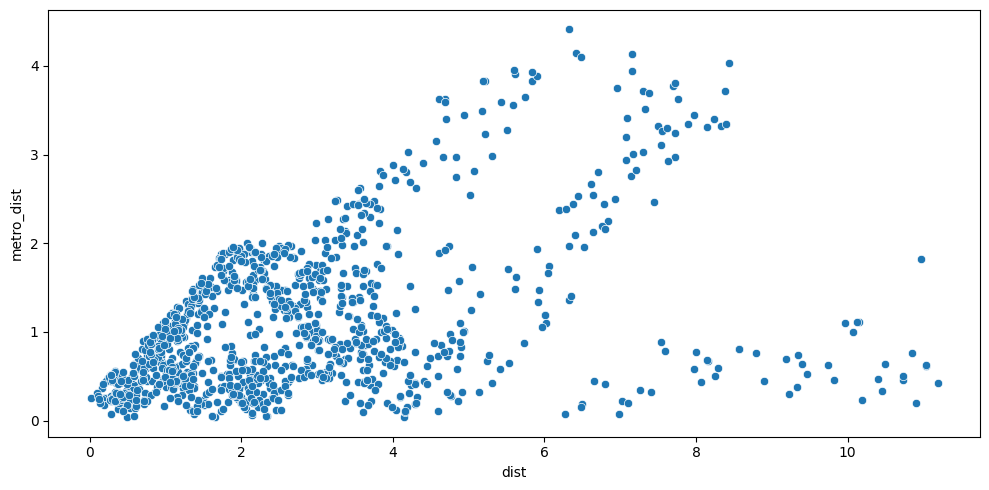

In [37]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=data, x='dist', y='metro_dist')
plt.tight_layout()
plt.show()

## Моделирование

In [80]:
train, test = train_test_split(data.drop(columns='cleanliness_rating_grouped'), train_size=0.8, random_state=1000)

In [81]:
grouped_categorical_columns = [
    'person_capacity_grouped',
    'bedrooms_grouped',
    'room_type_grouped',
    'host_is_superhost'
]

In [82]:
Y = train['realSum']

numerical_values = train[numerical_columns[1:]]
dummies = pd.get_dummies(train[grouped_categorical_columns], drop_first=True)

X = pd.concat([dummies, numerical_values], axis=1)
X = sm.add_constant(X)

In [83]:
Y_test = test['realSum']

test_numerical_values = test[numerical_columns[1:]]
test_dummies = pd.get_dummies(test[grouped_categorical_columns], drop_first=True)

X_test = pd.concat([test_dummies, test_numerical_values], axis=1)
X_test = sm.add_constant(X_test)

In [42]:
base_model = sm.OLS(Y.astype(np.float64), X.astype(np.float64))

In [179]:
fitted_base_model = base_model.fit()
with open('base_model.txt', 'w') as f:
    f.write(str(fitted_base_model.summary()))
fitted_base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                realSum   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     64.67
Date:                Sat, 16 Dec 2023   Prob (F-statistic):           9.38e-91
Time:                        11:16:06   Log-Likelihood:                -6364.9
No. Observations:                 882   AIC:                         1.275e+04
Df Residuals:                     872   BIC:                         1.280e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        632.4448     46.441     13.618      0.000     541.295     723.595
person_capacity_grouped_3     62.0827     44.755      1.387      0.166     -25.757     149.923
person_capacity_grouped_4+   175.1843     35.290      4.964      0.000     105.920     244.449
bedrooms_grouped_1            27.8455     42.902      0.649      0.516     -56.357     112.048
bedrooms_grouped_2           159.6794     55.394      2.883      0.004      50.959     268.400
bedrooms_grouped_3+          522.3748     66.161      7.895      0.000     392.521     652.229
room_type_grouped_room      -194.4248     25.261     -7.697      0.000    -244.005    -144.845
host_is_superhost_True        25.4161     24.877      1.022      0.307     -23.409      74.242
dist                         -40.8302      5.935     -6.880      0.000     -52.479     -29.182
metro_dist                   -25.9437     14.735     -1.761      0.079     -54.863       2.976
==============================================================================
Omnibus:                     1460.042   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1302438.869
Skew:                          10.058   Prob(JB):                         0.00
Kurtosis:                     190.179   Cond. No.                         32.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
vif = pd.DataFrame()
X_q = X.copy().astype(np.float64)

vif["variable"] = X_q.columns
vif["VIF"] = [variance_inflation_factor(X_q.values, i) for i in range(X_q.shape[1])]
vif

,variable,VIF
0,const,17.326166
1,person_capacity_grouped_3,1.129448
2,person_capacity_grouped_4+,2.230786
3,bedrooms_grouped_1,3.350003
4,bedrooms_grouped_2,3.886553
5,bedrooms_grouped_3+,2.400471
6,room_type_grouped_room,1.279187
7,host_is_superhost_True,1.038101
8,dist,1.250112
9,metro_dist,1.237629


In [46]:
het_white_result = pd.DataFrame(het_white(fitted_base_model.resid, X), index = ['LM', 'LM_P', 'F', 'F_P'])
het_white_result

,0
LM,49.744901
LM_P,0.192199
F,1.194001
F_P,0.189231


## Гипотеза 2

In [48]:
X_second = X.copy()

X_second['dist_room'] = X_second['room_type_grouped_room'] * X_second['dist']
X_second['dist_not_room'] = (~X_second['room_type_grouped_room']) * X_second['dist']
X_second = X_second.drop(columns='dist')

In [49]:
second_model = sm.OLS(Y.astype(np.float64), X_second.astype(np.float64))

In [50]:
fitted_second_model = second_model.fit()
fitted_second_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                realSum   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     61.68
Date:                Sat, 16 Dec 2023   Prob (F-statistic):           2.48e-94
Time:                        04:29:45   Log-Likelihood:                -6354.3
No. Observations:                 882   AIC:                         1.273e+04
Df Residuals:                     871   BIC:                         1.278e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        737.1090     51.221     14.391      0.000     636.577     837.641
person_capacity_grouped_3     62.4433     44.244      1.411      0.159     -24.395     149.281
person_capacity_grouped_4+   171.4090     34.898      4.912      0.000     102.916     239.902
bedrooms_grouped_1            10.5660     42.578      0.248      0.804     -73.001      94.133
bedrooms_grouped_2           155.5029     54.769      2.839      0.005      48.008     262.998
bedrooms_grouped_3+          534.0367     65.455      8.159      0.000     405.568     662.506
room_type_grouped_room      -332.6996     39.036     -8.523      0.000    -409.316    -256.084
host_is_superhost_True        23.2301     24.598      0.944      0.345     -25.048      71.508
metro_dist                   -26.1505     14.567     -1.795      0.073     -54.740       2.439
dist_room                    -24.1372      6.895     -3.501      0.000     -37.670     -10.604
dist_not_room                -77.1030      9.817     -7.854      0.000     -96.370     -57.836
==============================================================================
Omnibus:                     1479.775   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1423452.172
Skew:                          10.320   Prob(JB):                         0.00
Kurtosis:                     198.723   Cond. No.                         26.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Гипотеза 3

In [51]:
X_third = X_second.copy()

X_third['superhost_room'] = X_third['room_type_grouped_room'] * X_third['host_is_superhost_True']
X_third['superhost_entire_home'] = (~X_third['room_type_grouped_room']) * X_third['host_is_superhost_True']
# X_third['not_superhost_room'] = X_third['room_type_grouped_room'] * (~X_third['host_is_superhost_True'])
X_third['not_superhost_entire_home'] = (~X_third['room_type_grouped_room']) * (~X_third['host_is_superhost_True'])

X_third = X_third.drop(columns=[
    'host_is_superhost_True',
    'room_type_grouped_room',
])

In [52]:
third_model = sm.OLS(Y.astype(np.float64), X_third.astype(np.float64))

In [53]:
fitted_third_model = third_model.fit()
fitted_third_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                realSum   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     56.19
Date:                Sat, 16 Dec 2023   Prob (F-statistic):           1.13e-93
Time:                        04:30:20   Log-Likelihood:                -6353.7
No. Observations:                 882   AIC:                         1.273e+04
Df Residuals:                     870   BIC:                         1.279e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        412.0486     45.407      9.075      0.000     322.928     501.169
person_capacity_grouped_3     62.9227     44.242      1.422      0.155     -23.912     149.757
person_capacity_grouped_4+   168.2233     35.019      4.804      0.000      99.492     236.954
bedrooms_grouped_1            11.0725     42.576      0.260      0.795     -72.492      94.637
bedrooms_grouped_2           156.3440     54.770      2.855      0.004      48.848     263.840
bedrooms_grouped_3+          536.2132     65.480      8.189      0.000     407.695     664.731
metro_dist                   -25.1836     14.593     -1.726      0.085     -53.824       3.457
dist_room                    -24.3363      6.897     -3.529      0.000     -37.873     -10.800
dist_not_room                -76.9180      9.817     -7.835      0.000     -96.186     -57.650
superhost_room                 1.3527     31.869      0.042      0.966     -61.197      63.903
superhost_entire_home        372.9112     50.339      7.408      0.000     274.111     471.711
not_superhost_entire_home    317.2118     41.586      7.628      0.000     235.591     398.832
==============================================================================
Omnibus:                     1483.326   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1441942.729
Skew:                          10.369   Prob(JB):                         0.00
Kurtosis:                     199.993   Cond. No.                         25.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Оптимизация модели

In [59]:
X_cropped = X_third.copy()

In [60]:
X_cropped = X_cropped.drop(columns='bedrooms_grouped_1')
print(f'deleted bedrooms_grouped_1')

deleted bedrooms_grouped_1


In [61]:
model = sm.OLS(Y.astype(np.float64), X_cropped.astype(np.float64))
fm = model.fit()
fm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                realSum   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     61.87
Date:                Sat, 16 Dec 2023   Prob (F-statistic):           1.44e-94
Time:                        04:33:05   Log-Likelihood:                -6353.7
No. Observations:                 882   AIC:                         1.273e+04
Df Residuals:                     871   BIC:                         1.278e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        421.1216     29.047     14.498      0.000     364.111     478.133
person_capacity_grouped_3     62.1861     44.128      1.409      0.159     -24.424     148.796
person_capacity_grouped_4+   168.3130     34.998      4.809      0.000      99.622     237.004
bedrooms_grouped_2           146.3747     39.097      3.744      0.000      69.640     223.110
bedrooms_grouped_3+          526.2244     53.004      9.928      0.000     422.194     630.254
metro_dist                   -25.1955     14.585     -1.728      0.084     -53.821       3.430
dist_room                    -24.1096      6.838     -3.526      0.000     -37.531     -10.689
dist_not_room                -76.9554      9.811     -7.844      0.000     -96.211     -57.699
superhost_room                 1.7977     31.806      0.057      0.955     -60.629      64.224
superhost_entire_home        374.1875     50.072      7.473      0.000     275.911     472.464
not_superhost_entire_home    318.1873     41.394      7.687      0.000     236.943     399.431
==============================================================================
Omnibus:                     1483.257   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1441499.960
Skew:                          10.369   Prob(JB):                         0.00
Kurtosis:                     199.963   Cond. No.                         18.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
X_cropped = X_cropped.drop(columns='superhost_room')
print(f'deleted superhost_room')

deleted superhost_room


In [63]:
final_model = sm.OLS(Y.astype(np.float64), X_cropped.astype(np.float64))
fitted_final_model = final_model.fit()
fitted_final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                realSum   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     68.82
Date:                Sat, 16 Dec 2023   Prob (F-statistic):           1.69e-95
Time:                        04:33:09   Log-Likelihood:                -6353.7
No. Observations:                 882   AIC:                         1.273e+04
Df Residuals:                     872   BIC:                         1.278e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        421.7817     26.581     15.868      0.000     369.612     473.952
person_capacity_grouped_3     62.1167     44.086      1.409      0.159     -24.410     148.643
person_capacity_grouped_4+   168.1390     34.843      4.826      0.000      99.754     236.524
bedrooms_grouped_2           146.4822     39.028      3.753      0.000      69.882     223.082
bedrooms_grouped_3+          526.2985     52.957      9.938      0.000     422.360     630.237
metro_dist                   -25.1443     14.548     -1.728      0.084     -53.698       3.409
dist_room                    -24.1186      6.832     -3.530      0.000     -37.528     -10.709
dist_not_room                -76.9644      9.804     -7.850      0.000     -96.207     -57.722
superhost_entire_home        373.5542     48.775      7.659      0.000     277.825     469.284
not_superhost_entire_home    317.5422     39.767      7.985      0.000     239.492     395.592
==============================================================================
Omnibus:                     1483.252   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1441490.261
Skew:                          10.368   Prob(JB):                         0.00
Kurtosis:                     199.962   Cond. No.                         17.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
vif = pd.DataFrame()
X_q = X_cropped.copy().astype(np.float64)

vif["variable"] = X_q.columns
vif["VIF"] = [variance_inflation_factor(X_q.values, i) for i in range(X_q.shape[1])]
vif

,variable,VIF
0,const,5.821562
1,person_capacity_grouped_3,1.124065
2,person_capacity_grouped_4+,2.230367
3,bedrooms_grouped_2,1.978845
4,bedrooms_grouped_3+,1.577430
5,metro_dist,1.237524
6,dist_room,2.003289
7,dist_not_room,2.419589
8,superhost_entire_home,1.831330
9,not_superhost_entire_home,3.051137


In [73]:
het_white_result = pd.DataFrame(het_white(fitted_final_model.resid, X), index = ['LM', 'LM_P', 'F', 'F_P'])
if het_white_result.loc['LM_P'][0] < 0.05:
    print('Model is heteroskedastic')
else:
    print('Model is homoskedastic')
het_white_result

Model is homoskedastic


,0
LM,49.266963
LM_P,0.205221
F,1.181851
F_P,0.202529


## Проверка прогностических способностей

In [84]:
X_test_transform = X_test.copy()

X_test_transform['dist_room'] = X_test_transform['room_type_grouped_room'] * X_test_transform['dist']
X_test_transform['dist_not_room'] = (~X_test_transform['room_type_grouped_room']) * X_test_transform['dist']
X_test_transform = X_test_transform.drop(columns='dist')

X_test_transform['superhost_room'] = X_test_transform['room_type_grouped_room'] * X_test_transform['host_is_superhost_True']
X_test_transform['superhost_entire_home'] = (~X_test_transform['room_type_grouped_room']) * X_test_transform['host_is_superhost_True']
X_test_transform['not_superhost_entire_home'] = (~X_test_transform['room_type_grouped_room']) * (~X_test_transform['host_is_superhost_True'])

X_test_transform = X_test_transform.drop(columns=[
    'host_is_superhost_True',
    'room_type_grouped_room',
    'superhost_room',
    'bedrooms_grouped_1',
])

In [107]:
predict_vals = fitted_final_model.predict(X_test_transform.astype(np.float64))
print(f'R squared: {r2_score(Y_test, predict_vals):.5f}')

R squared: 0.44628


In [110]:
predictions = fitted_final_model.get_prediction(X_test_transform.astype(np.float64))
prediction_results = predictions.summary_frame(0.05)[['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper']]
prediction_results

,mean,mean_se,mean_ci_lower,mean_ci_upper
455,955.676207,31.693147,893.472442,1017.879971
963,578.922966,41.165651,498.127630,659.718303
1071,398.902628,23.054358,353.654111,444.151145
259,873.934239,53.307659,769.307925,978.560552
382,699.474057,39.810137,621.339170,777.608943
...,...,...,...,...
677,345.223609,17.170922,311.522444,378.924775
398,237.999276,38.492546,162.450410,313.548142
167,322.435542,16.829350,289.404774,355.466309
530,232.255955,32.162848,169.130312,295.381598


## Диагностика модели

In [173]:
influence = fitted_base_model.get_influence()
hat_values = influence.hat_matrix_diag
studentized_residuals = influence.resid_studentized_external

base_outlier_hat_value = hat_values > hat_values.mean() * 3
base_outlier_studentized_residuals = studentized_residuals > 3

In [174]:
influence = fitted_final_model.get_influence()
hat_values = influence.hat_matrix_diag
studentized_residuals = influence.resid_studentized_external

final_outlier_hat_value = hat_values > hat_values.mean() * 3
final_outlier_studentized_residuals = studentized_residuals > 3

In [175]:
X_third[final_outlier_hat_value & base_outlier_hat_value]

,const,person_capacity_grouped_3,person_capacity_grouped_4+,bedrooms_grouped_1,bedrooms_grouped_2,bedrooms_grouped_3+,metro_dist,dist_room,dist_not_room,superhost_room,superhost_entire_home,not_superhost_entire_home
738,1.0,True,False,False,True,False,4.030014,8.436536,0.000000,True,False,False
645,1.0,True,False,False,False,True,0.496723,0.000000,3.078985,False,False,True
432,1.0,False,True,False,True,False,0.503960,0.000000,10.729830,False,True,False
968,1.0,True,False,True,False,False,0.623755,9.738196,0.000000,False,False,False
463,1.0,True,False,False,True,False,0.627236,0.000000,11.037736,False,False,True
448,1.0,True,False,False,False,True,1.558226,0.000000,2.096664,False,False,True
638,1.0,True,False,False,False,True,0.834389,0.000000,4.075584,False,False,True


In [176]:
X_third[final_outlier_studentized_residuals & base_outlier_studentized_residuals]

,const,person_capacity_grouped_3,person_capacity_grouped_4+,bedrooms_grouped_1,bedrooms_grouped_2,bedrooms_grouped_3+,metro_dist,dist_room,dist_not_room,superhost_room,superhost_entire_home,not_superhost_entire_home
1098,1.0,False,False,True,False,False,1.436054,0.0,2.375833,False,False,True
970,1.0,False,True,False,False,True,2.039112,0.0,2.980734,False,False,True
574,1.0,False,True,False,True,False,1.655335,0.0,2.975607,False,False,True
935,1.0,True,False,True,False,False,0.226204,0.0,1.165050,False,False,True
7,1.0,False,True,False,False,True,1.458404,0.0,1.686807,False,True,False
271,1.0,False,True,False,False,True,0.910320,0.0,1.162761,False,False,True
99,1.0,False,True,False,False,True,1.402539,0.0,1.615295,False,False,True
158,1.0,False,True,False,False,True,1.096036,0.0,0.970919,False,True,False
